<a href="https://colab.research.google.com/github/v-artur/Golden_Oreos/blob/main/Modeling1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install some of the dependencies

In [1]:
%%capture
!pip install fastdtw
!pip install pysptk      
!pip install pyworld

In [2]:
#wget and gdown stopped working over time so this became the only option to load the data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import files from Google drive

In [3]:
#old links, because gdown is not reliable on the long run
#!pip install gdown
#!gdown https://drive.google.com/uc?id=1Uu55cqiSZLCj0fAU7QoXxJSIunsuqHEX
#!gdown https://drive.google.com/u/0/uc?id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP
#!gdown https://drive.google.com/u/0/uc?id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog


#the data
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1vtZchVzl424pSQBXQ8EBxvVOzcEQPKIp" -O features.zip && rm -rf /tmp/cookies.txt
#reconstruction module
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1_eeG0d_r-RqazUkr-ZRPNC6L13sHYwIP" -O reconstructWave.py && rm -rf /tmp/cookies.txt
#Melfiltebank applier
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1Bjf3ncRe8CcWHl3i0HxRo4unRYkz2fog" -O MelFilterBank.py && rm -rf /tmp/cookies.txt


#extracting it
import zipfile
#zip_ref = zipfile.ZipFile("/content/features.zip", 'r')
#zip_ref.extractall("/content/features")

zip_ref = zipfile.ZipFile("/content/drive/My Drive/DeepLearning/features.zip", 'r')
zip_ref.extractall("/content/features")

zip_ref.close()

#creating folders for the synthesized audiofiles for the model types

!mkdir synth_audio_bn        #bottleneck
!mkdir synth_audio_dnn       #FC-DNN
!mkdir synth_audio_bigru     #BiGRU 

In [4]:
#copying files from drive to the main folder for shorter paths
!cp "/content/drive/My Drive/DeepLearning/reconstructWave.py" "/content/reconstructWave.py"
!cp "/content/drive/My Drive/DeepLearning/MelFilterBank.py" "/content/MelFilterBank.py"

Necessary models and functions

In [5]:
import tensorflow as tf
from tensorflow.keras import regularizers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Input, Bidirectional, GRU, Flatten
import numpy as np


#Baseline Bottleneck FC-DNN

def create_bottleneck_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(Input(shape=(inputsize)))
    model.add(Dense(128, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(4, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(outputsize))
    return model

#Baseline Normal FC-DNN

def create_dnn_model(inputsize, outputsize):
    model = tf.keras.Sequential()
    model.add(Input(shape=(inputsize)))
    model.add(Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu", kernel_initializer='HeNormal'))
    model.add(Dropout(0.2))
    model.add(Dense(outputsize))
    return model

#Baseline BiGRU 

def create_bigru_model(channels, outputsize):
  model = tf.keras.Sequential()
  model.add(Input(shape=(9, channels)))
  model.add(Bidirectional(GRU(units=100, return_sequences=True, dropout=0.2)))
  model.add(Bidirectional(GRU(units=50, return_sequences=True, dropout=0.2)))
  model.add(Flatten())
  model.add(Dense(outputsize))
  return model


#reshape function for bigru model input
def bigru_reshape(array):
  array_temp1 = np.reshape(array, (array.shape[0], 9, int(array.shape[1]/9)))
  return array_temp1

In [6]:
#For audio reconstruction and MCD measure 
#dependencies
import reconstructWave as rW
import MelFilterBank as mel
import numpy as np
import librosa
from scipy.io import wavfile
import pysptk
from scipy.spatial.distance import euclidean
import os
from fastdtw import fastdtw

# functions for MCD calculations 
# (source: https://github.com/ttslr/python-MCD?fbclid=IwAR2OFaz3-8kTfhJXC7F-cmTTHkY-egEzZdSYHsC0agwPw58N2G3hqhfdVNY)


#The following function converts a wav file into a format which can be used to evaluate the MCD score
def readmgc(filename):
    sr, x = wavfile.read(filename)
    assert sr == 16000
    x = x.astype(np.float64)
    frame_length = 1024
    hop_length = 256  
    frames = librosa.util.frame(x, frame_length=frame_length, hop_length=hop_length).astype(np.float64).T
    frames *= pysptk.blackman(frame_length)
    assert frames.shape[1] == frame_length 
    order = 25
    alpha = 0.41
    stage = 5
    gamma = -1.0 / stage

    mgc = pysptk.mgcep(frames, order, alpha, gamma)
    mgc = mgc.reshape(-1, order + 1)
    print("mgc of {} is ok!".format(filename))
    return mgc


# variable for the compute_mcd function 
natural_folder = '/content/features/'


#this function returns the average MCD score for the reconstructed WAV file by a chosen model
def compute_mcd(synth_folder):
  '''
  :param synth_folder: the folder in which the reconstructed WAV files can be found
  '''

  # computing the MCD
  files = os.listdir(synth_folder)
  for subject in files:
    
    # this is necessary because of the .ipynb_checkpoints files
    if subject.startswith('.'):
      continue

    print("Processing -----------{}".format(subject))

    #computational parameters
    _logdb_const = 10.0 / np.log(10.0) * np.sqrt(2.0)
    s = 0.0
    framesTot = 0
    

    # obtaining the mgc features
    subject_ID = subject[0:6]
    filename1 = natural_folder + subject_ID + '_orig_audio.wav'
    mgc1 = readmgc(filename1)
    filename2 = synth_folder + subject_ID + '_predicted.wav'
    mgc2 = readmgc(filename2)
  
    x = mgc1
    y = mgc2
    
    # calculating the mcd
    distance, path = fastdtw(x, y, dist=euclidean)
  
    distance/= (len(x) + len(y))
    pathx = list(map(lambda l: l[0], path))
    pathy = list(map(lambda l: l[1], path))
    x, y = x[pathx], y[pathy]

    frames = x.shape[0]
    framesTot  += frames

    z = x - y
    s += np.sqrt((z * z).sum(-1)).sum()

    MCD_value = _logdb_const * float(s) / float(framesTot)

    print(f"MCD of {subject_ID}: {MCD_value}")


#Reconstructing the WAV file from the predicted mel-log spectrogram (Griffin-Lim method)
def createAudio(spectrogram, audiosr=16000, winLength=0.05, frameshift=0.01):
    mfb = mel.MelFilterBank(int((audiosr*winLength)/2+1), spectrogram.shape[1], audiosr)
    hop = int(spectrogram.shape[0])
    rec_audio = np.array([])
    for_reconstruction = mfb.fromLogMels(spectrogram)
    for w in range(0,spectrogram.shape[0],hop):
        spec = for_reconstruction[w:min(w+hop,for_reconstruction.shape[0]),:]
        rec = rW.reconstructWavFromSpectrogram(spec,spec.shape[0]*spec.shape[1],fftsize=int(audiosr*winLength),overlap=int(winLength/frameshift))
        rec_audio = np.append(rec_audio,rec)
    scaled = np.int16(rec_audio/np.max(np.abs(rec_audio)) * 32767)
    return scaled

In [7]:
#Setting seed
tf.keras.utils.set_random_seed(1234)

# 1.) One person model

### Training the baseline bottleneck FC-DNN structure for one person




In [8]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile



data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights0.hdf5', save_best_only=True, verbose=1)

    model = create_bottleneck_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights0.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 6.04030, saving model to weights0.hdf5

Epoch 2: val_loss improved from 6.04030 to 4.22561, saving model to weights0.hdf5

Epoch 3: val_loss improved from 4.22561 to 3.22016, saving model to weights0.hdf5

Epoch 4: val_loss improved from 3.22016 to 2.59529, saving model to weights0.hdf5

Epoch 5: val_loss improved from 2.59529 to 2.57195, saving model to weights0.hdf5

Epoch 6: val_loss improved from 2.57195 to 2.54055, saving model to weights0.hdf5

Epoch 7: val_loss did not improve from 2.54055

Epoch 8: val_loss improved from 2.54055 to 2.25447, saving model to weights0.hdf5

Epoch 9: val_loss improved from 2.25447 to 2.08316, saving model to weights0.hdf5

Epoch 10: val_loss did not improve from 2.08316

Epoch 11: val_loss did not improve from 2.08316

Epoch 12: val_loss improved from 2.08316 to 1.99279, saving model to weights0.hdf5

Epoch 13: val_loss improved from 1.99279 to 1.74865, saving model to weights0.hdf5

Epoch 14: val_loss improv

### Training the baseline normal FC-DNN structure for one person


In [9]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 100
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights1.hdf5', save_best_only=True, verbose=1)

    model = create_dnn_model(numComps, spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights1.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_dnn/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 3.63817, saving model to weights1.hdf5

Epoch 2: val_loss improved from 3.63817 to 3.19754, saving model to weights1.hdf5

Epoch 3: val_loss improved from 3.19754 to 2.74673, saving model to weights1.hdf5

Epoch 4: val_loss improved from 2.74673 to 2.44087, saving model to weights1.hdf5

Epoch 5: val_loss improved from 2.44087 to 2.35735, saving model to weights1.hdf5

Epoch 6: val_loss improved from 2.35735 to 2.13421, saving model to weights1.hdf5

Epoch 7: val_loss improved from 2.13421 to 2.01494, saving model to weights1.hdf5

Epoch 8: val_loss did not improve from 2.01494

Epoch 9: val_loss did not improve from 2.01494

Epoch 10: val_loss improved from 2.01494 to 1.94304, saving model to weights1.hdf5

Epoch 11: val_loss improved from 1.94304 to 1.71123, saving model to weights1.hdf5

Epoch 12: val_loss improved from 1.71123 to 1.57693, saving model to weights1.hdf5

Epoch 13: val_loss improved from 1.57693 to 1.51088, saving model to weigh

### Training the baseline BiGRU model structure for one person

In [10]:
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile


data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #We don't use PCA here

    X_train = bigru_reshape(X_train)
    X_val = bigru_reshape(X_val)
    X_test = bigru_reshape(X_test)


    # Bottleneck model
    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights2.hdf5', save_best_only=True, verbose=1)

    model = create_bigru_model(X_train.shape[2], spectrogram.shape[1])
    model.compile(loss='mse', optimizer='adam', metrics=['mse'])
    model.fit(X_train, y_train, batch_size=64, 
              epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
              callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights2.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)


    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 1.41212, saving model to weights2.hdf5

Epoch 2: val_loss improved from 1.41212 to 0.79139, saving model to weights2.hdf5

Epoch 3: val_loss improved from 0.79139 to 0.69216, saving model to weights2.hdf5

Epoch 4: val_loss improved from 0.69216 to 0.55912, saving model to weights2.hdf5

Epoch 5: val_loss improved from 0.55912 to 0.43158, saving model to weights2.hdf5

Epoch 6: val_loss improved from 0.43158 to 0.38394, saving model to weights2.hdf5

Epoch 7: val_loss improved from 0.38394 to 0.34763, saving model to weights2.hdf5

Epoch 8: val_loss improved from 0.34763 to 0.32278, saving model to weights2.hdf5

Epoch 9: val_loss improved from 0.32278 to 0.29786, saving model to weights2.hdf5

Epoch 10: val_loss improved from 0.29786 to 0.29385, saving model to weights2.hdf5

Epoch 11: val_loss did not improve from 0.29385

Epoch 12: val_loss improved from 0.29385 to 0.25392, saving model to weights2.hdf5

Epoch 13: val_loss did not improve from

### MCD score evaluation for the basline models

In [11]:
import matplotlib.pyplot as plt
import librosa
import pyworld

In [12]:
#source: https://github.com/SamuelBroughton/Mel-Cepstral-Distortion/blob/master/mel-cepstral-distortion.ipynb
def load_wav(wav_file, sr):
    """
    Load a wav file with librosa.
    :param wav_file: path to wav file
    :param sr: sampling rate
    :return: audio time series numpy array
    """
    wav, _ = librosa.load(wav_file, sr=sr, mono=True)

    return wav

In [13]:
#loading in the original and the reconstructed spectrograms
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_bn/sub-01_predicted.wav', 16000)
rec_dnn = load_wav('/content/synth_audio_dnn/sub-01_predicted.wav', 16000)
rec_bigru = load_wav('/content/synth_audio_bigru/sub-01_predicted.wav', 16000)

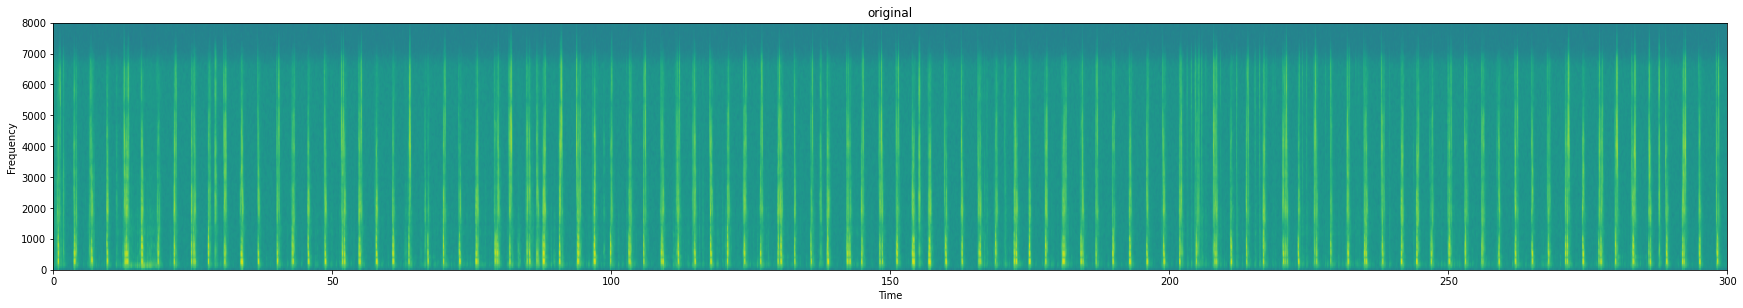

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


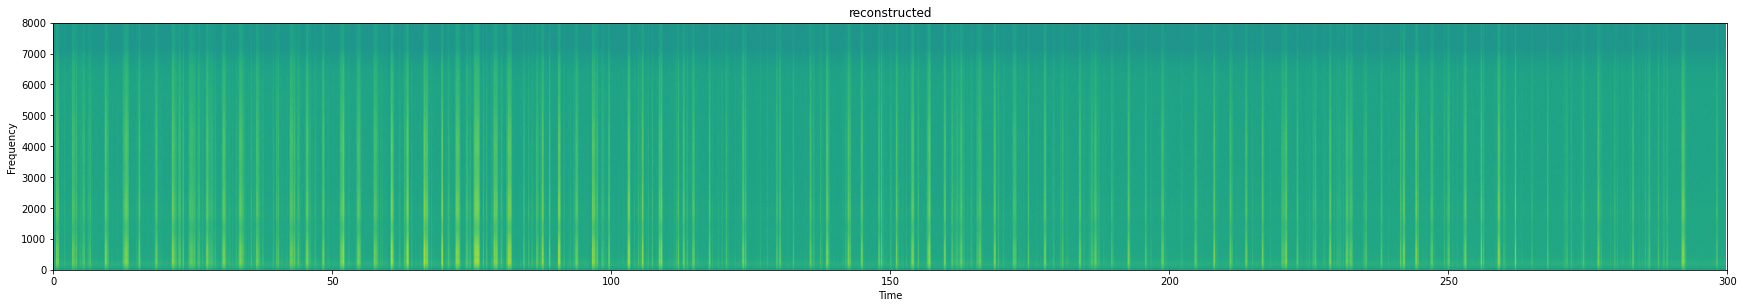

In [14]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

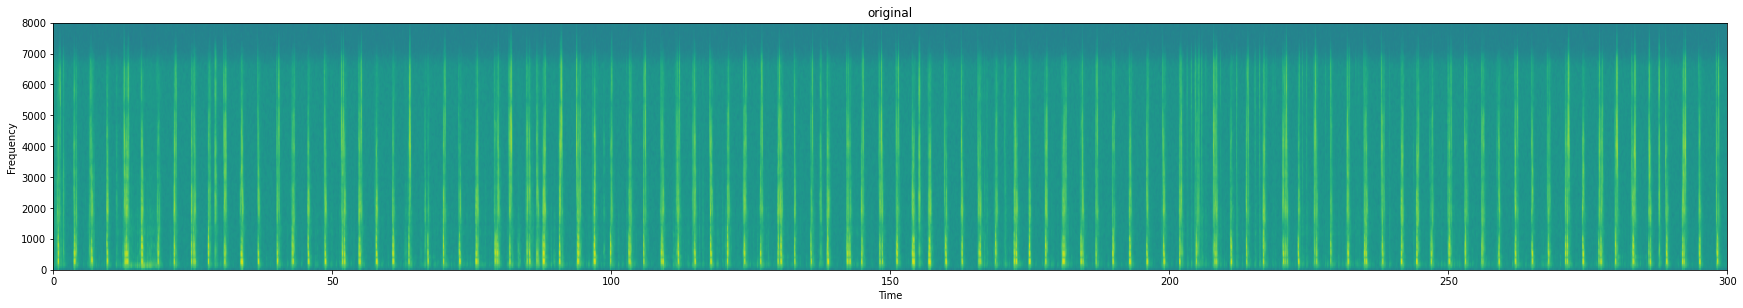

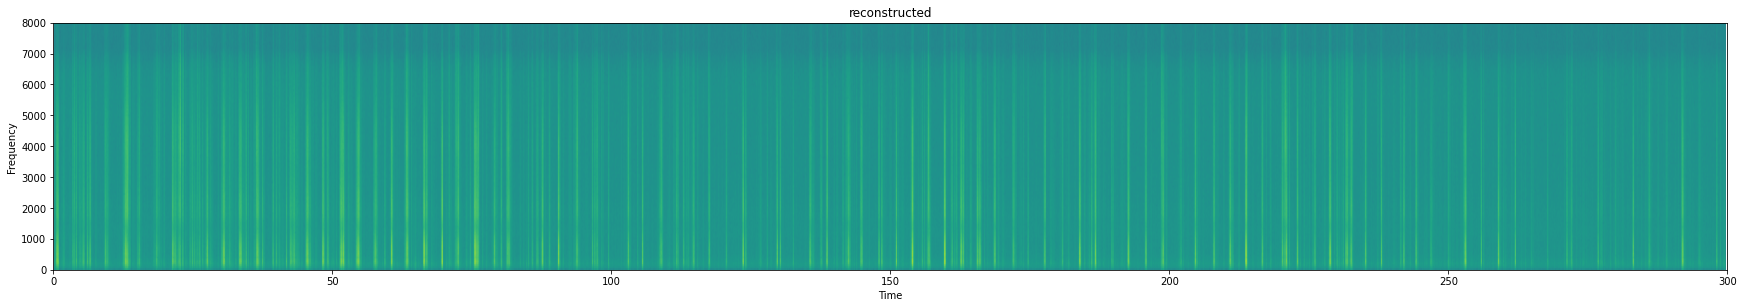

In [15]:
#from the normal DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_dnn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

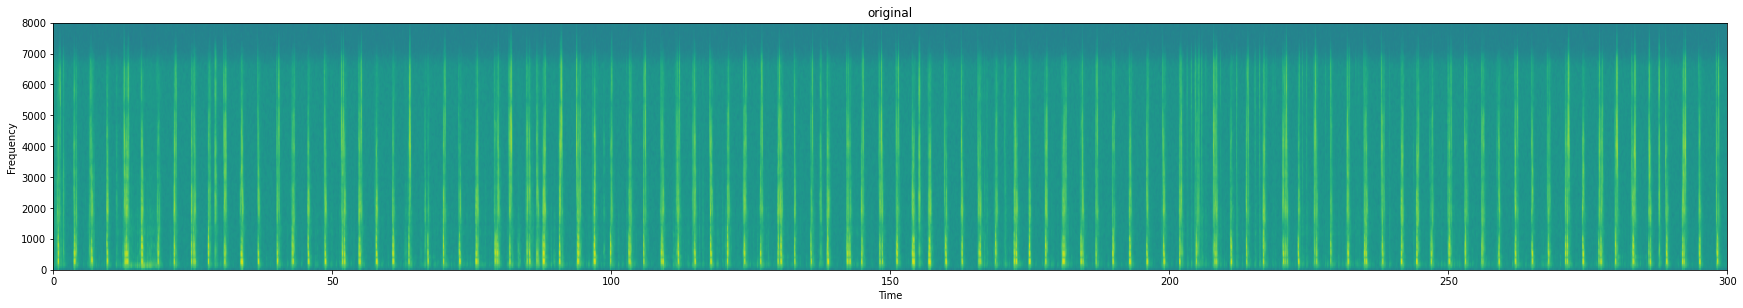

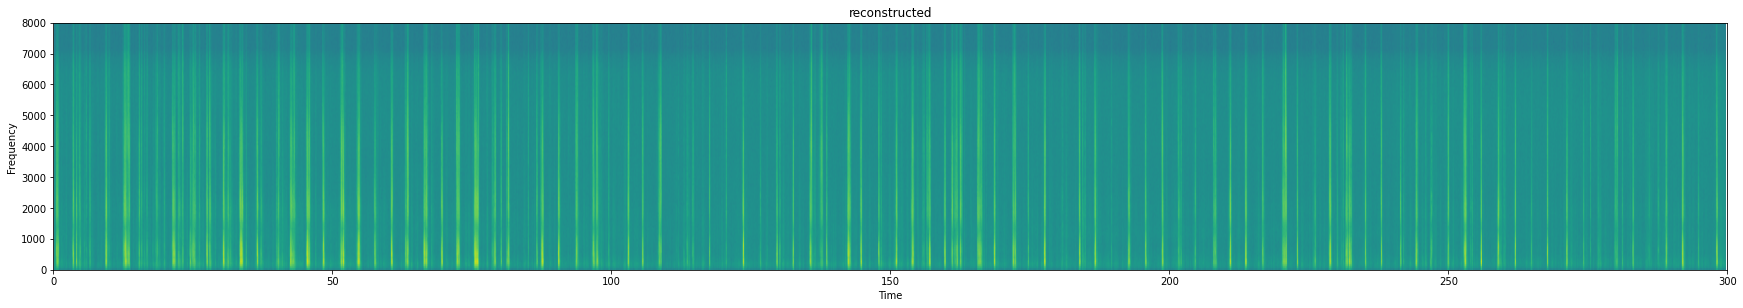

In [16]:
#from the BiGRU model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bigru, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [17]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn/sub-01_predicted.wav is ok!
MCD of sub-01: 8.224135014335


In [18]:
# From the normal FC-DNN model
compute_mcd('/content/synth_audio_dnn/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_dnn/sub-01_predicted.wav is ok!
MCD of sub-01: 3.8664546658117436


In [19]:
# From the BiGRU model
compute_mcd('/content/synth_audio_bigru/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bigru/sub-01_predicted.wav is ok!
MCD of sub-01: 5.460220196152292


# 2.) Optimizing the baseline one person type models

We are going to use keras tuner for this task.

## Tuning the Bottleneck FC DNN model

In [20]:
%%capture
!pip install keras-tuner

In [21]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from scipy.stats import pearsonr
from sklearn.model_selection import KFold, train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.io.wavfile as wavfile

In [22]:
def create_bottleneck_model_opt(hp):

  '''
  :param hp: collection of the hyperparameters

  Here we follow the default syntax for hypertuning with keras-tuner.
  For each layer we give an interval and a stepsize for the tuner to choose hyperparameters from.
  The structure has to be close to the original, so the intervals were chosen accordingly.
  '''

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(200))) #input size is fixed to 200

  hp_units_1 = hp.Int('units_1', min_value=128, max_value=256, step=32)    #the amount of nodes can be: 128, 160, 192, 224, 256
  model.add(tf.keras.layers.Dense(units = hp_units_1, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_2 = hp.Int('units_2', min_value=64, max_value=96, step=8)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_3 = hp.Int('units_3', min_value=16, max_value=32, step=4)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  hp_units_4 = hp.Int('units_4', min_value=4, max_value=8, step=2)
  model.add(tf.keras.layers.Dense(units = hp_units_4, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_4', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  model.add(tf.keras.layers.Dense(16, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_5', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05)))

  model.add(tf.keras.layers.Dense(23)) #output

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model

In [29]:
!rm -r synth_audio_bn_opt   #removing the directories to avoid glitches when rerunning
!rm -r bottleneck_opt*

In [30]:
!mkdir synth_audio_bn_opt   #making a directory to save the prediction to

In [31]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Fine-tuning the parameters
    tuner = kt.Hyperband(create_bottleneck_model_opt,
                         objective='val_loss',
                         max_epochs=15,
                         factor=3,
                         directory='/content/bottleneck_opt' + str(k),
                         project_name='bn_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    tuner.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=10, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights3.hdf5', save_best_only=True, verbose=1)



    model = tuner.hypermodel.build(best_hps)
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights3.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bn_opt/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 1.75634, saving model to weights3.hdf5

Epoch 2: val_loss improved from 1.75634 to 1.53798, saving model to weights3.hdf5

Epoch 3: val_loss improved from 1.53798 to 1.23387, saving model to weights3.hdf5

Epoch 4: val_loss did not improve from 1.23387

Epoch 5: val_loss improved from 1.23387 to 1.02159, saving model to weights3.hdf5

Epoch 6: val_loss did not improve from 1.02159

Epoch 7: val_loss improved from 1.02159 to 0.97389, saving model to weights3.hdf5

Epoch 8: val_loss did not improve from 0.97389

Epoch 9: val_loss did not improve from 0.97389

Epoch 10: val_loss did not improve from 0.97389

Epoch 11: val_loss did not improve from 0.97389

Epoch 12: val_loss did not improve from 0.97389

Epoch 13: val_loss improved from 0.97389 to 0.75646, saving model to weights3.hdf5

Epoch 14: val_loss did not improve from 0.75646

Epoch 15: val_loss did not improve from 0.75646

Epoch 16: val_loss did not improve from 0.75646

Epoch 17: val_loss

Let's see the result of the tuning.

In [32]:
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bn = load_wav('/content/synth_audio_bn_opt/sub-01_predicted.wav', 16000)

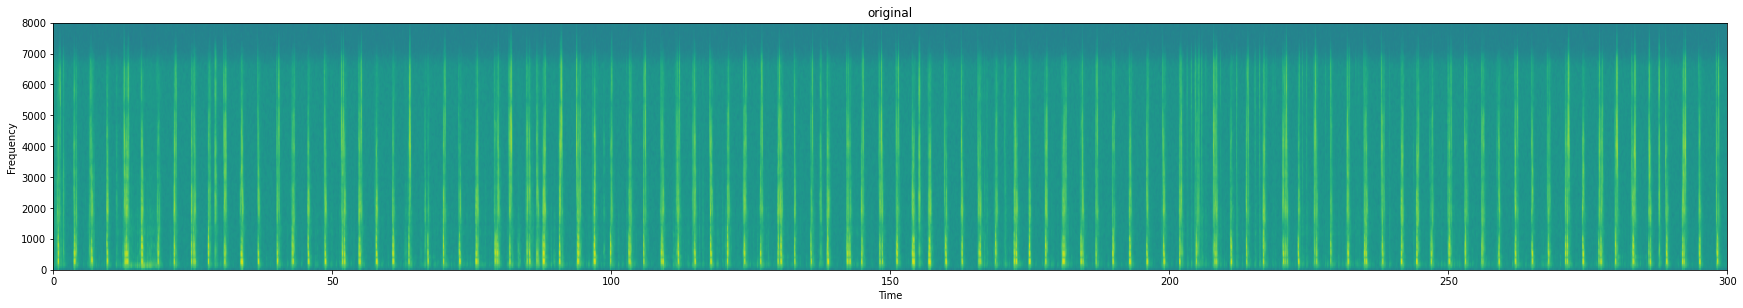

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


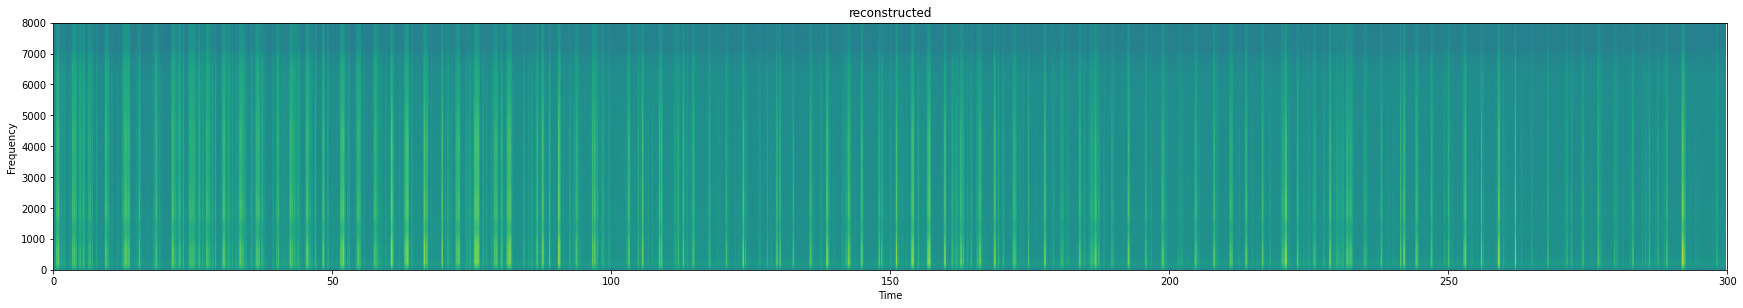

In [33]:
#from the optimized bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [34]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bn_opt/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bn_opt/sub-01_predicted.wav is ok!
MCD of sub-01: 4.050790809875618


## Tuning the Normal FC DNN model

In [35]:
def create_dnn_model_opt(hp):

  '''
  :param hp: collection of the hyperparameters

  Here we follow the default syntax for hypertuning with keras-tuner.
  For each layer we give an interval and a stepsize for the tuner to choose hyperparameters from.
  The structure has to be close to the original, so the intervals were chosen accordingly.
  '''

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(200)))

  hp_units_1 = hp.Int('units_1', min_value=100, max_value=150, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_1, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_1', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  hp_units_2 = hp.Int('units_2', min_value=100, max_value=140, step=10)
  model.add(tf.keras.layers.Dense(units = hp_units_2, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_2', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  hp_units_3 = hp.Int('units_3', min_value=60, max_value=80, step=5)
  model.add(tf.keras.layers.Dense(units = hp_units_3, activation="relu", kernel_initializer='HeNormal'))
  model.add(tf.keras.layers.Dropout(rate=hp.Float('dropout_3', min_value = 0.0, max_value = 0.2, default = 0.1, step = 0.04)))

  model.add(tf.keras.layers.Dense(40))

  model.add(tf.keras.layers.Dense(23)) #output

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  
  return model

In [36]:
!rm -r synth_audio_fcdnn_opt  #necessary for rerunning, to avoid glitches when overwriting the reconstructed spectrogram
!rm -r fcdnn_opt*

rm: cannot remove 'synth_audio_fcdnn_opt': No such file or directory
rm: cannot remove 'fcdnn_opt*': No such file or directory


In [37]:
!mkdir synth_audio_fcdnn_opt

In [38]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters
nfolds = 5
kf = KFold(nfolds,shuffle=False)
pca = PCA()
numComps = 200
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000

#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #Fit PCA to training data
    pca.fit(X_train)
    #Tranform data 
    X_train = np.dot(X_train, pca.components_[:numComps,:].T)
    X_val = np.dot(X_val, pca.components_[:numComps,:].T)
    X_test = np.dot(X_test, pca.components_[:numComps,:].T)

    # Fine-tuning the parameters
    tuner1 = kt.Hyperband(create_dnn_model_opt,
                         objective='val_loss',
                         max_epochs=15,
                         factor=3,
                         directory='/content/fcdnn_opt' + str(k),
                         project_name='dnn_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    tuner1.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner1.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=20, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights4.hdf5', save_best_only=True, verbose=1)



    model = tuner1.hypermodel.build(best_hps)
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights4.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))

#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_fcdnn_opt/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 2.03600, saving model to weights4.hdf5

Epoch 2: val_loss improved from 2.03600 to 1.72964, saving model to weights4.hdf5

Epoch 3: val_loss improved from 1.72964 to 1.33533, saving model to weights4.hdf5

Epoch 4: val_loss improved from 1.33533 to 1.17343, saving model to weights4.hdf5

Epoch 5: val_loss improved from 1.17343 to 0.98318, saving model to weights4.hdf5

Epoch 6: val_loss improved from 0.98318 to 0.84655, saving model to weights4.hdf5

Epoch 7: val_loss improved from 0.84655 to 0.76533, saving model to weights4.hdf5

Epoch 8: val_loss improved from 0.76533 to 0.67993, saving model to weights4.hdf5

Epoch 9: val_loss improved from 0.67993 to 0.67555, saving model to weights4.hdf5

Epoch 10: val_loss improved from 0.67555 to 0.64666, saving model to weights4.hdf5

Epoch 11: val_loss did not improve from 0.64666

Epoch 12: val_loss improved from 0.64666 to 0.57873, saving model to weights4.hdf5

Epoch 13: val_loss improved from 0.5787

In [39]:
rec_dnn = load_wav('/content/synth_audio_fcdnn_opt/sub-01_predicted.wav', 16000)

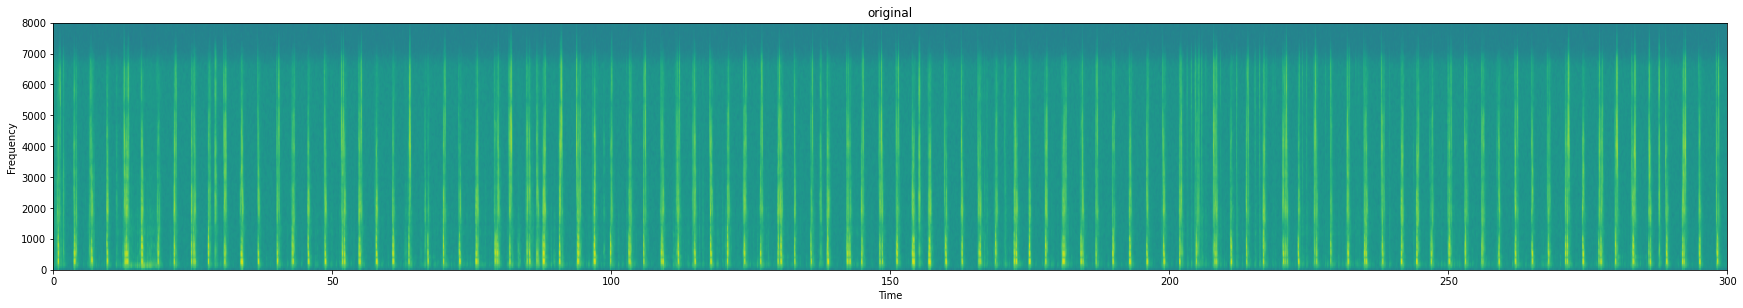

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


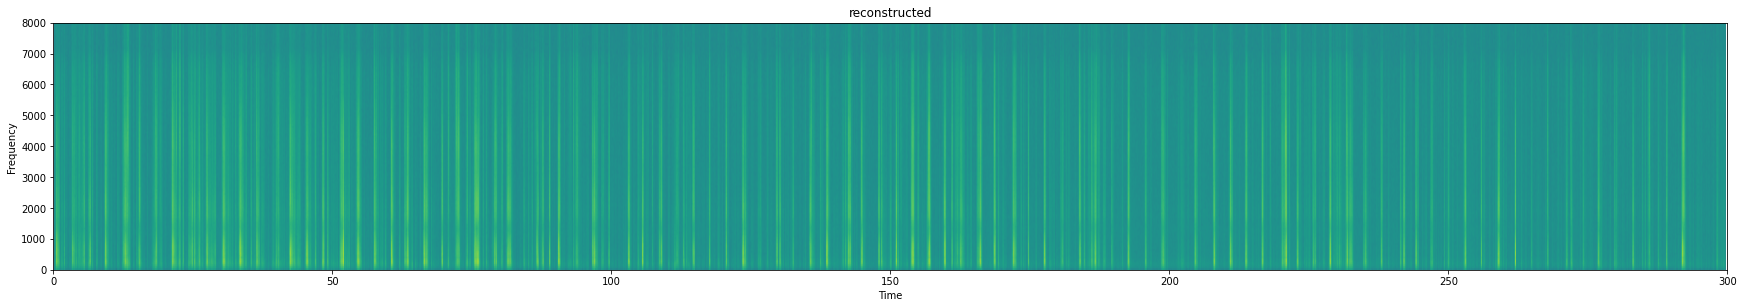

In [40]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_dnn, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [41]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_fcdnn_opt/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_fcdnn_opt/sub-01_predicted.wav is ok!
MCD of sub-01: 7.580112617529111


## Tuning the BiGRU model

In [42]:
def create_bigru_model_opt(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(9, 127)))  #in the case of the one person model we have a strict shape for channels
  model.add(Bidirectional(GRU(units=hp.Choice('units_1', [90, 100, 110, 120]), return_sequences=True, dropout=hp.Float('dropout_1', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05))))
  model.add(Bidirectional(GRU(units=hp.Choice('units_2', [45, 50, 55, 60]), return_sequences=True, dropout=hp.Float('dropout_2', min_value = 0.0, max_value = 0.4, default = 0.2, step = 0.05))))
  model.add(Flatten())
  model.add(Dense(23))

  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mse',
                metrics=['mse'])
  return model

In [43]:
!rm -r synth_audio_bigru_opt   #removing the directories to avoid glitches when running multiple times
!rm -r bigru_opt*

rm: cannot remove 'synth_audio_bigru_opt': No such file or directory
rm: cannot remove 'bigru_opt*': No such file or directory


In [44]:
!mkdir synth_audio_bigru_opt

In [45]:
data = np.load(r'/content/features/sub-01_feat.npy')
spectrogram = np.load(r'/content/features/sub-01_spec.npy')

#Inital parameters for prediction
nfolds = 5
kf = KFold(nfolds,shuffle=False)
val_split = 0.2

#Audio Reconstruction parameters
winLength = 0.05
frameshift = 0.01
audiosr = 16000


#Initialize an empty spectrogram to save the reconstruction to
rec_spec = np.zeros(spectrogram.shape)
#Save the correlation coefficients for each fold
rs = np.zeros((nfolds,spectrogram.shape[1]))
for k,(train, test) in enumerate(kf.split(data)):
          
    #Train, validation and test data
    X_train_temp = data[train,:]
    y_train_temp = spectrogram[train,:]
    X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, test_size=val_split, random_state=0)
    X_test = data[test,:]
    y_test = spectrogram[test,:] # this one might not be needed
    
    #Standardization
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train[:] = scaler.transform(X_train)
    X_val[:] = scaler.transform(X_val)
    X_test[:] = scaler.transform(X_test)

    #We don't use PCA here

    X_train = bigru_reshape(X_train)
    X_val = bigru_reshape(X_val)
    X_test = bigru_reshape(X_test)


    early_stopping=EarlyStopping(patience=25, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights5.hdf5', save_best_only=True, verbose=1)

    tuner2 = kt.Hyperband(create_bigru_model_opt,
                         objective='val_loss',
                         max_epochs=15,
                         factor=3,
                         directory='/content/bigru_opt' + str(k),
                         project_name='bigru_opt' + str(k))
    
    stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    tuner2.search(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), verbose=0, shuffle=True, callbacks=[stop_early])
    best_hps=tuner2.get_best_hyperparameters(num_trials=3)[0]

    #Applying the best model
    early_stopping=EarlyStopping(patience=20, verbose=1, min_delta=1e-5)
    checkpointer=ModelCheckpoint(filepath='weights5.hdf5', save_best_only=True, verbose=1)



    model = tuner2.hypermodel.build(best_hps)
    model.fit(X_train, y_train, batch_size=64, 
                     epochs=100, verbose=0, validation_data=(X_val, y_val), shuffle=True,
                     callbacks=[checkpointer, early_stopping])
            
    #predict with the best weights
    model.load_weights('weights5.hdf5')
    rec_spec[test, :] = model.predict(X_test, verbose=0)

    #Evaluate reconstruction of this fold
    for specBin in range(spectrogram.shape[1]):
         r, p = pearsonr(spectrogram[test, specBin], rec_spec[test, specBin])
         rs[k,specBin] = r


#Show evaluation result
print("")
print('Mean correlation:', np.mean(rs))


#Make and save the synthesized audio
reconstructedWav = createAudio(rec_spec,audiosr=audiosr,winLength=winLength,frameshift=frameshift)
wavfile.write(os.path.join('/content/synth_audio_bigru_opt/sub-01_predicted.wav'),int(audiosr),reconstructedWav)


Epoch 1: val_loss improved from inf to 1.46101, saving model to weights5.hdf5

Epoch 2: val_loss improved from 1.46101 to 0.79584, saving model to weights5.hdf5

Epoch 3: val_loss improved from 0.79584 to 0.66895, saving model to weights5.hdf5

Epoch 4: val_loss improved from 0.66895 to 0.65950, saving model to weights5.hdf5

Epoch 5: val_loss improved from 0.65950 to 0.42983, saving model to weights5.hdf5

Epoch 6: val_loss improved from 0.42983 to 0.38236, saving model to weights5.hdf5

Epoch 7: val_loss improved from 0.38236 to 0.37393, saving model to weights5.hdf5

Epoch 8: val_loss improved from 0.37393 to 0.33767, saving model to weights5.hdf5

Epoch 9: val_loss improved from 0.33767 to 0.31636, saving model to weights5.hdf5

Epoch 10: val_loss improved from 0.31636 to 0.31099, saving model to weights5.hdf5

Epoch 11: val_loss improved from 0.31099 to 0.29931, saving model to weights5.hdf5

Epoch 12: val_loss improved from 0.29931 to 0.27168, saving model to weights5.hdf5

Epoc

In [46]:
orig = load_wav('/content/features/sub-01_orig_audio.wav', 16000)
rec_bigru = load_wav('/content/synth_audio_bigru_opt/sub-01_predicted.wav', 16000)

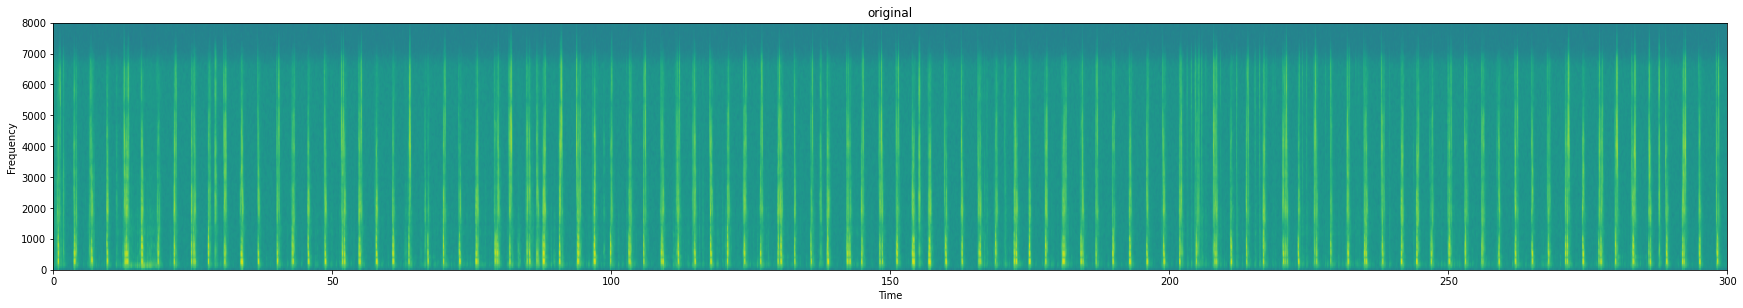

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


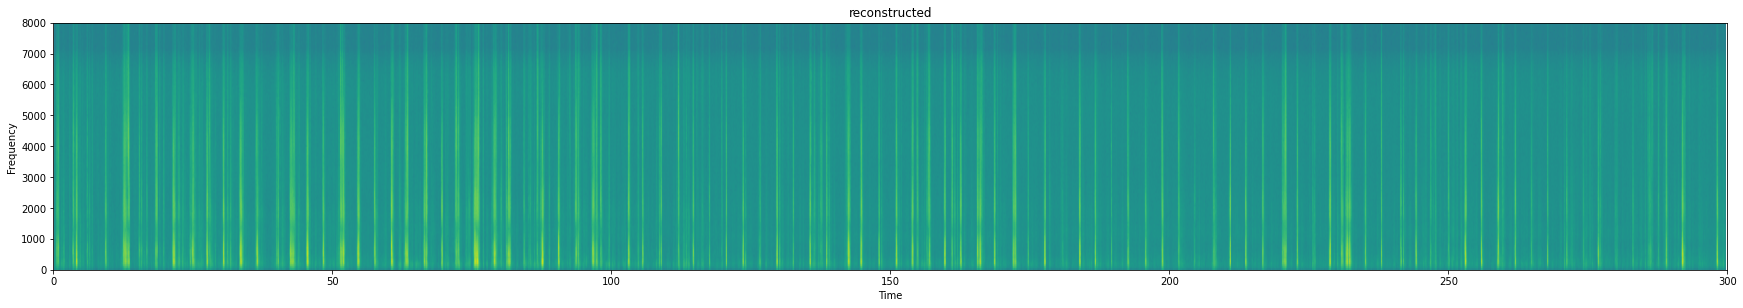

In [47]:
#from the bottleneck DNN model
#plotting the spectograms of the original sub-o1_orig_audio.wav file and the reconstructed sub-01_predicted.wav file
plt.figure(figsize = (30,10))
plt.subplot(211)
plt.specgram(orig, Fs=16000)
plt.title('original')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

plt.figure(figsize = (30,10))
plt.subplot(212)
plt.specgram(rec_bigru, Fs=16000)
plt.title('reconstructed')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.xlim(0,300)  
plt.show()

In [49]:
# From the bottleneck FC-DNN model
compute_mcd('/content/synth_audio_bigru_opt/')

Processing -----------sub-01_predicted.wav
mgc of /content/features/sub-01_orig_audio.wav is ok!
mgc of /content/synth_audio_bigru_opt/sub-01_predicted.wav is ok!
MCD of sub-01: 4.88300783734595
